# Effect of Initialization on Optimization Trajectory 
## Visualizing how Initialization effects optimization

This notebook demonstrates the importance of initialization in an optimization problem. The [Beale](https://www.sfu.ca/~ssurjano/beale.html) Function, a two dimentional function is chosen to make visualizations simple.

### The Optimization Problem
In simple words, finding a minimum value for a given equation is considered as optimization. This has many applications in real life - finding the fastest path when traveling from one place to other, job shop scheduling, air traffic management etc,. The optimization has been the back bone of machine learning, where the algorithms are expected to extract knowledge from huge volumes of data.

Optimization plays a major role Neural Networks, where there are millions of parameters and the goal is to find the right set of parameters to correctly represent the data. There has been a lot of research in this field and many algorithms have been developed for effective optimization. Eventhough the performance of the optimizer has improved a lot, there is another problem that the optimization depends upon i.e. the initial point. The trajectory of optimization is largely dependant on the initialisation. This has been studied and numerous initialization techniques have been proposed to effectively exploit the power of optimization algorithms.

In this notebook we are going to see how the initialzation can affect the performance of some of the optimization algorithms until day. Although, we are using a two dimensional problem here since it is easy to visualize, the initialization problem becomes more prevalent when there are millions of parameters (Neural Networks).


### The Task
Initialize x, y and use gradient descent algorithms to find the optimal values of x and y such that the value of the Beale function is zero (or as low as possible).

### The Beale Function
$$
f(x, y) =  (1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 +(2.625 - x + xy^3)^2
$$

* Beale function is a multimodal non-convex continuos function defined in two dimentions.
* It is usually evaluated in the range $(x,y) \in [-4.5, 4.5]$. 
* The function has only one global minimum at $(x, y) = (3, 0.5)$.


### A brief introduction to optimization algorithms
We are going to consider three popular optimization algorithms, since we are more concerned about the initialization these will be sufficient for our analysis.
1. **Stochastic Gradient Descent** - The stochastic gradient descent algorithm performs one update at a time computing gradients at each step.
2. **Momentum** - Overcomes the difficulty of slow updates of stochastic gradient descent by considering the momentum of gradients over a period of time.
3. **Adam** - Considered to be the most popular optimization algorithm. It takes into consideration the first and second moments i.e. the exponentially decaying average of past gradients and squared gradients.

A more detailed explanation about gradient descent optimization algorithms, please read this [post](https://ruder.io/optimizing-gradient-descent/) by [Sebastian Ruder](https://ruder.io/).

#### Import required libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings("ignore")

### Plotting the value of Beale Function in input range
We shall plot how the value of the Beale function varies in the input region. For that we need to prepare a meshgrid of values denoting $x, y$ (denoted here with $w1$ and $w2$). 

Please refer this [tutorial](http://louistiao.me/notes/visualizing-and-animating-optimization-algorithms-with-matplotlib/) on how to produce these plots.

In [2]:
f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

w1_min, w1_max, w1_step = -4.5, 4.5, .2
w2_min, w2_max, w2_step = -4.5, 4.5, .2

minima_ = [3, 0.5]

w1, w2 = np.meshgrid(np.arange(w1_min, w1_max + w1_step, w1_step), np.arange(w2_min, w2_max + w2_step, w2_step))
losses = f(w1, w2)

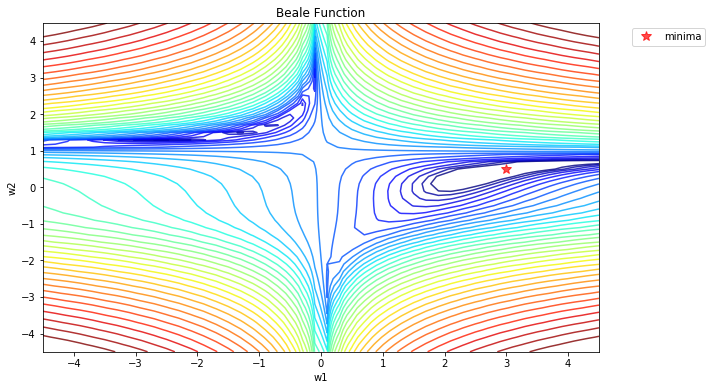

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.contour(w1, w2, losses, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet, alpha = 0.8)
ax.plot(*minima_, 'r*', color='r',markersize=10, alpha=0.7, label='minima')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_xlim((w1_min, w1_max))
ax.set_ylim((w2_min, w2_max))
ax.legend(bbox_to_anchor=(1.2, 1.))
ax.set_title("Beale Function")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

### Setting up Parameters 
* As we are going to minimize the **Beale** function, we can use the **nn.Module** class from **PyTorch** to define our fuction in the form of a class. 
* We have two parameters $x, y$, which here are being denoted as $w1, w2$. 
* The terms $a, b, c$ in the forward function represent the three individual terms in the equation. (these were seperated as there were some issues with gradient calculations.)

In [4]:
class Net_Beale(torch.nn.Module):
    def __init__(self, x, y):
        super(Net_Beale, self).__init__()
        self.w1 = torch.nn.Parameter(torch.tensor([x]))
        self.w2 = torch.nn.Parameter(torch.tensor([y]))
        
    def forward(self):
        a = (1.5 - self.w1 + self.w1*self.w2)**2
        b = (2.25 - self.w1 + self.w1*self.w2**2)**2
        c = (2.625 - self.w1 + self.w1*self.w2**3)**2
        return a+b+c

### Saving the optimization trajectory
Since we are interested in tracking the path of the optimization, we need to collect the parameters at at each step/desired steps and save them for plotting. 

The below function initialises the parameters of the network, initializes an optimizer and runs the optimization for the specified number of steps while collecting the path of the parameters.

In [5]:
def get_trajectory(x, y, optim, lr, epochs, interval=1):
    
    net = Net_Beale(x,y)
    
    if optim == "sgd":
        optim = torch.optim.SGD(net.parameters(), lr)
    elif optim == "mom":
        optim = torch.optim.SGD(net.parameters(), lr, momentum=0.9)
    elif optim == "adam":
        optim = torch.optim.Adam(net.parameters(), lr)
        
    w_1s = []
    w_2s = []

    for i in range(epochs):
        optim.zero_grad()
        o = net()
        o.backward()
        
        if i % interval == 0:
            w_1s.append(net.w1.item())
            w_2s.append(net.w2.item())
        optim.step()
        
    w_1s.append(net.w1.item())
    w_2s.append(net.w2.item())
    trajectory = np.array([w_1s, w_2s])   
    
    return trajectory

### Comparision between trajectories

After collecting the paths of parameters with different algorithms, we are going to plot them on the Beale Function Contour plot. The below function takes in the initial position, list of optimizers and corresponding learning rates and epochs and plots the trajectories of algorithms with specified settings.  

In [6]:
def compare_trajectories(x, y, epochs, optims, lrs):
    
    colors = ['k', 'g', 'b', 'r', 'y', 'c', 'm']
    
    trajectories = []
    names = []
    for ep, optim, lr in zip(epochs, optims, lrs):
        trajectory = get_trajectory(float(x), float(y), optim=optim, lr=lr, epochs=ep)
        
        names.append(optim)
        trajectories.append(trajectory)
        
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.contour(w1, w2, losses, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet, alpha = 0.5)

    for i, trajectory in enumerate(trajectories):
        ax.quiver(trajectory[0,:-1], trajectory[1,:-1], trajectory[0,1:]-trajectory[0,:-1], 
                  trajectory[1,1:]-trajectory[1,:-1], scale_units='xy', angles='xy', scale=1, 
                  color=colors[i], label=names[i], alpha=0.8)
        
    start_ =[x,y]
    ax.plot(*start_, 'r*', color='k',markersize=10, alpha=0.7, label='start')
    ax.plot(*minima_, 'r*', color='r',markersize=10, alpha=0.7, label='minima')
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_xlim((w1_min, w1_max))
    ax.set_ylim((w2_min, w2_max))
    ax.set_title("Initial point - ({},{})".format(x,y))
    ax.legend(bbox_to_anchor=(1.2, 1.))
    fig.suptitle("Optimization Trajectory")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

### Trying Different Initial Points

After setting up everything, we are now ready to compare the three algorithms with different initial points.

The learning rates observed to be working in this problem
* SGD      - 0.0001
* momentum - 0.0001
* Adam     - 0.01


We are going to use the same learning rate for different initial points considered for respective algorithms to keep the analysis simple and since we are not doing hyperparameter tuning.

In [ ]:
epochs = [10000] * 3
optims = ['sgd', 'mom', 'adam']
lrs = [0.0001, 0.0001, 0.01] 

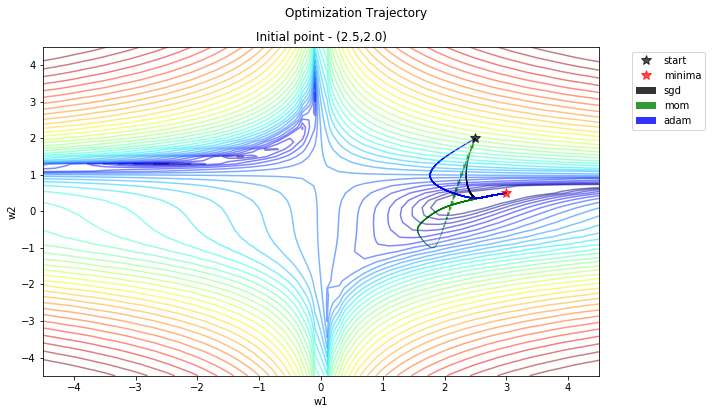

In [7]:
#  A point closer to minima 
x = 2.5
y = 2.

compare_trajectories(x, y, epochs, optims, lrs)

All the three reach the global minima, lets move a little further and see what happens.

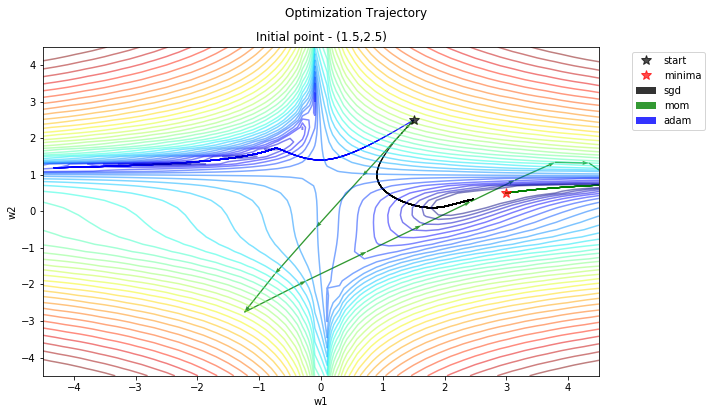

In [8]:
# A little away in the same region
x = 1.5
y = 2.5

compare_trajectories(x, y, epochs, optims, lrs)

SGD and Momentum move towards the global minimum and adam is going to the local minimum.


Selecting extreme initial points, as we will see in the below examples.
SGD and momentum behave crazy and adam seems to behave well, although not directed towards the global minimum always.

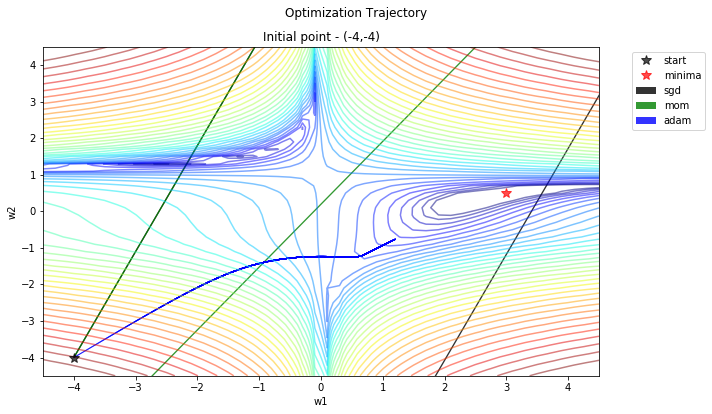

In [9]:
# Lower left region
x = -4
y = -4

compare_trajectories(x, y, epochs, optims, lrs)

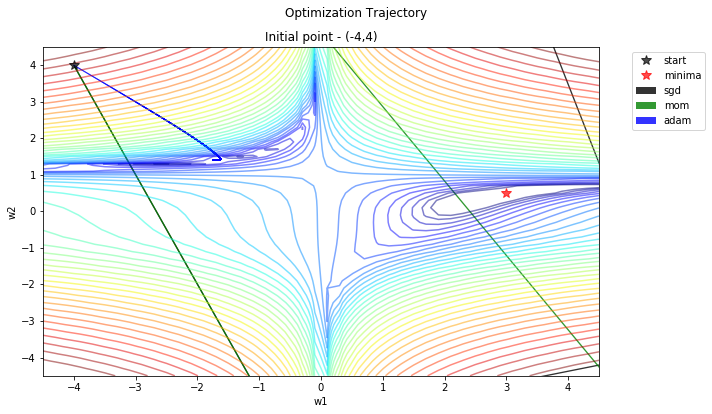

In [10]:
# Upper left region
x = -4
y = 4

compare_trajectories(x, y, epochs, optims, lrs)

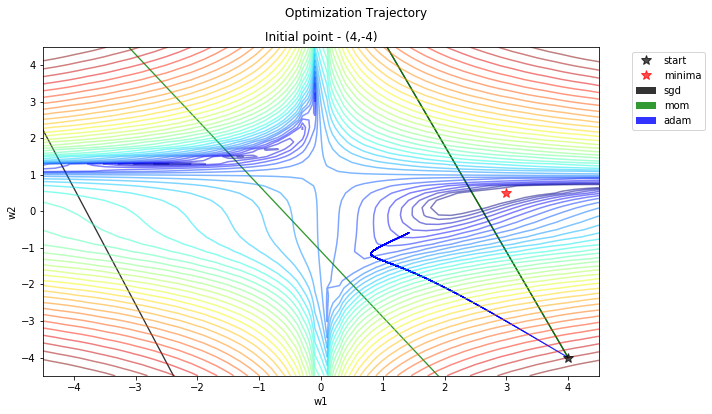

In [11]:
# Lower right region
x = 4
y = -4

compare_trajectories(x, y, epochs, optims, lrs)

### Conclusion
The initial point plays a crucial role in optimization problems. Here we are trying to solve a two dimensional problem which is fairly easy when compared to finding a minima when we have a large dataset and more than million parameters (dimensions).

Although we are not tuning the hyperparameters here, we can effectively drive the optimization with the right set of hyperparameters.


### References

1. https://mitpress.mit.edu/books/optimization-machine-learning
2. https://en.wikipedia.org/wiki/Test_functions_for_optimization
3. http://benchmarkfcns.xyz/benchmarkfcns/bealefcn.html
4. https://ruder.io/optimizing-gradient-descent/
5. http://louistiao.me/notes/visualizing-and-animating-optimization-algorithms-with-matplotlib/
6. https://communities.sas.com/t5/SAS-Communities-Library/Mathematical-Optimization-in-our-Daily-Lives/ta-p/504724#